In [2]:
pip install opensmile librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 17.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import opensmile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew


In [4]:

# -------------------------------
# Audio Feature Extraction (OpenSMILE)
# -------------------------------
columns_to_keep = ['pcm_zcr_sma', 'pcm_RMSenergy_sma', 'voicingFinalUnclipped_sma'] + \
                  [f'mfcc_sma[{i}]' for i in range(1, 13)] + ['file']

def process_file(file_path):
    """Load audio and extract low-level features using OpenSMILE."""
    signal, sr = librosa.load(file_path, sr=None)
    smile = opensmile.Smile(feature_set=opensmile.FeatureSet.ComParE_2016,
                            feature_level=opensmile.FeatureLevel.LowLevelDescriptors)
    df = smile.process_signal(signal, sr)
    return df

def filter_features(df):
    """Keep only selected features."""
    return df[columns_to_keep]

def calculate_statistical_features(group):
    """Calculate statistical features for a group corresponding to one file."""
    stats = {}
    for column in group.columns:
        if column == 'file':
            continue
        data = group[column].dropna()
        if len(data) > 0:
            max_val = data.max()
            max_pos = np.argmax(data.values) / len(data)
            value_range = data.max() - data.min()
            median_val = data.median()
            kurtosis_val = kurtosis(data)
            skewness_val = skew(data)
            std_dev = data.std()
            x = np.arange(len(data))
            lin_reg_coef = np.polyfit(x, data, 1)
            quad_error = np.sum((np.polyval(lin_reg_coef, x) - data) ** 2)
            stats[column + '_max'] = max_val
            stats[column + '_max_pos'] = max_pos
            stats[column + '_range'] = value_range
            stats[column + '_median'] = median_val
            stats[column + '_kurtosis'] = kurtosis_val
            stats[column + '_skewness'] = skewness_val
            stats[column + '_std_dev'] = std_dev
            stats[column + '_lin_reg_coef_0'] = lin_reg_coef[0]
            stats[column + '_lin_reg_coef_1'] = lin_reg_coef[1]
            stats[column + '_quad_error'] = quad_error
    return pd.Series(stats)

def extract_audio_features(audio_path):
    """Extract fixed-length feature vector from an audio file using OpenSMILE."""
    df = process_file(audio_path)
    df['file'] = os.path.basename(audio_path)
    filtered_df = filter_features(df)
    stats_series = calculate_statistical_features(filtered_df)
    features = stats_series.values.astype(np.float32)
    return features

# -------------------------------
# Text Embedding (LaBSE)
# -------------------------------
LABSE_MODEL_NAME = "sentence-transformers/LaBSE"
labse_tokenizer = AutoTokenizer.from_pretrained(LABSE_MODEL_NAME)
labse_model = AutoModel.from_pretrained(LABSE_MODEL_NAME)
labse_model.eval()

def text_to_embedding(text):
    """Convert text to a fixed-length embedding using LaBSE."""
    inputs = labse_tokenizer(text,
                             add_special_tokens=True,
                             max_length=128,
                             padding='max_length',
                             truncation=True,
                             return_attention_mask=True,
                             return_tensors='pt')
    with torch.no_grad():
        outputs = labse_model(**inputs)
    embedding = outputs.pooler_output.squeeze(0)
    return embedding.float()

# -------------------------------
# MultiModal Dataset
# -------------------------------
class MultiModalDataset(Dataset):
    def __init__(self, audio_paths, texts, labels):
        """
        audio_paths: list of full paths to audio files.
        texts: list of corresponding transcriptions.
        labels: list or array of integer labels.
        """
        self.audio_paths = audio_paths
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_feat = extract_audio_features(self.audio_paths[idx])
        audio_feat_tensor = torch.tensor(audio_feat)
        text_emb = text_to_embedding(self.texts[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {'audio': audio_feat_tensor,
                'text': text_emb,
                'label': label}

# -------------------------------
# Attention-based Fusion Classifier (Early Fusion) for Multi-Class
# -------------------------------
class AttentionFusionClassifier(nn.Module):
    def __init__(self, audio_input_dim, text_input_dim, common_dim=256, num_classes=5, num_heads=2):
        """
        audio_input_dim: Dimension of the audio feature vector (e.g., 150).
        text_input_dim: Dimension of the LaBSE embedding (e.g., 768).
        common_dim: Dimension to project both modalities.
        num_classes: Number of output classes (here, 5).
        num_heads: Number of heads for multi-head attention.
        """
        super(AttentionFusionClassifier, self).__init__()
        self.audio_fc = nn.Sequential(
            nn.LayerNorm(audio_input_dim),
            nn.Linear(audio_input_dim, common_dim),
            nn.ReLU()
        )
        self.text_fc = nn.Sequential(
            nn.LayerNorm(text_input_dim),
            nn.Linear(text_input_dim, common_dim),
            nn.ReLU()
        )
        # Stack modalities into a sequence (seq_len=2)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=common_dim, num_heads=num_heads, batch_first=False)
        self.classifier = nn.Sequential(
            nn.Linear(common_dim, common_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(common_dim, num_classes)
        )
    
    def forward(self, audio, text):
        audio_proj = self.audio_fc(audio)    # (batch, common_dim)
        text_proj = self.text_fc(text)       # (batch, common_dim)
        # Stack modalities: resulting shape (batch, 2, common_dim)
        combined = torch.stack([audio_proj, text_proj], dim=1)
        # Transpose to (seq_len, batch, common_dim)
        combined = combined.transpose(0, 1)
        attn_output, _ = self.multihead_attn(combined, combined, combined)
        fused = torch.mean(attn_output, dim=0)  # (batch, common_dim)
        logits = self.classifier(fused)
        return logits

# -------------------------------
# Training and Evaluation Functions
# -------------------------------
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for batch in dataloader:
        audio = batch['audio'].to(device)
        text = batch['text'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(audio, text)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * audio.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_samples += audio.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    return epoch_loss, epoch_acc

def eval_model(model, dataloader, loss_fn, device, target_names):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in dataloader:
            audio = batch['audio'].to(device)
            text = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(audio, text)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * audio.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += audio.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    report = classification_report(all_labels, all_preds, target_names=target_names)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return epoch_loss, epoch_acc, report, conf_matrix

def plot_confusion_matrix(matrix, target_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names,
                yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()




tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [5]:
# -------------------------------
# Main Routine
# -------------------------------
def main():
    # Update paths for multi-class data
    excel_path = "/kaggle/input/multiclass-data/TELUGU_METADATA_SHEETS.xlsx"
    # Directories for each class:
    path1 = "/kaggle/input/multiclass-data/Character Assassination"
    path2 = "/kaggle/input/multiclass-data/Gender"
    path3 = "/kaggle/input/multiclass-data/Political"
    path4 = "/kaggle/input/multiclass-data/Religion"
    path5 = "/kaggle/input/multiclass-data/Non Hate"
    directories = [path1, path2, path3, path4, path5]
    
    # Load dataset from Excel (using the MultiClass sheet)
    data_df = pd.read_excel(excel_path, sheet_name="MultiClass")
    # Map class labels to integers
    label_mapping = {
        "C": 0,
        "G": 1,
        "P": 2,
        "R": 3,
        "NH": 4
    }
    data_df['CLASS LABEL'] = data_df['CLASS LABLE'].map(label_mapping)
    data_df = data_df.dropna(subset=['AUDIO FILE NAME', 'TEXT', 'CLASS LABLE'])
    
    audio_paths = []
    texts = []
    labels = []
    
    # For each row, search through the five directories by file base name
    for idx, row in data_df.iterrows():
        file_name = str(row['AUDIO FILE NAME']).strip()
        found = False
        for directory in directories:
            for fname in os.listdir(directory):
                base, ext = os.path.splitext(fname)
                if base.strip() == file_name and ext.lower() in ['.mp3', '.wav']:
                    audio_paths.append(os.path.join(directory, fname))
                    texts.append(str(row['TEXT']))
                    labels.append(int(row['CLASS LABEL']))
                    found = True
                    break
            if found:
                break
        if not found:
            print(f"Audio file not found for: {file_name}")
    
    if len(audio_paths) == 0:
        raise ValueError("No audio files found. Check file names and directory paths.")
    
    # Split data with stratification on labels
    train_audio, test_audio, train_texts, test_texts, train_labels, test_labels = train_test_split(
        audio_paths, texts, labels, test_size=0.2, random_state=42, stratify=labels)
    
    train_dataset = MultiModalDataset(train_audio, train_texts, train_labels)
    test_dataset = MultiModalDataset(test_audio, test_texts, test_labels)
    
    BATCH_SIZE = 8
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    audio_dim = 150  
    text_dim = 768
    num_classes = 5
    model = AttentionFusionClassifier(audio_input_dim=audio_dim, text_input_dim=text_dim,
                                      common_dim=256, num_classes=num_classes, num_heads=2)
    model.to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Define target names for the 5 classes
    target_names = ["CA", "Gender", "Political", "Religion", "Non Hate"]
    
    NUM_EPOCHS = 10
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        val_loss, val_acc, val_report, conf_matrix = eval_model(model, test_loader, loss_fn, device, target_names)
        print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f}")
        print("Classification Report:")
        print(val_report)
        plot_confusion_matrix(conf_matrix, target_names)
    
    torch.save(model.state_dict(), "attention_fusion_multiclass_model.pth")
    print("Model saved as attention_fusion_multiclass_model.pth")



Using device: cpu
Epoch 1/10 | Train Loss: 1.5448 | Train Acc: 0.3292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 1.4443 | Validation Acc: 0.3471
Classification Report:
              precision    recall  f1-score   support

          CA       0.00      0.00      0.00        27
      Gender       0.00      0.00      0.00        22
   Political       0.00      0.00      0.00        14
    Religion       0.00      0.00      0.00        16
    Non Hate       0.35      1.00      0.52        42

    accuracy                           0.35       121
   macro avg       0.07      0.20      0.10       121
weighted avg       0.12      0.35      0.18       121



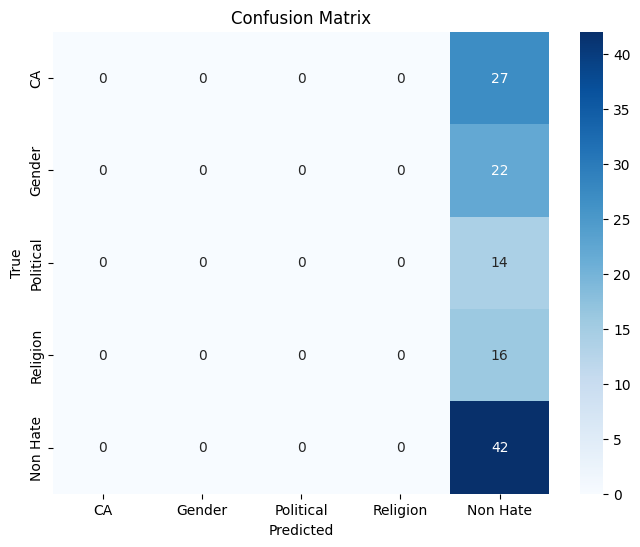

Epoch 2/10 | Train Loss: 1.1806 | Train Acc: 0.5417
Validation Loss: 0.9901 | Validation Acc: 0.6364
Classification Report:
              precision    recall  f1-score   support

          CA       0.57      0.78      0.66        27
      Gender       0.73      0.36      0.48        22
   Political       0.89      0.57      0.70        14
    Religion       1.00      0.06      0.12        16
    Non Hate       0.62      0.93      0.74        42

    accuracy                           0.64       121
   macro avg       0.76      0.54      0.54       121
weighted avg       0.71      0.64      0.59       121



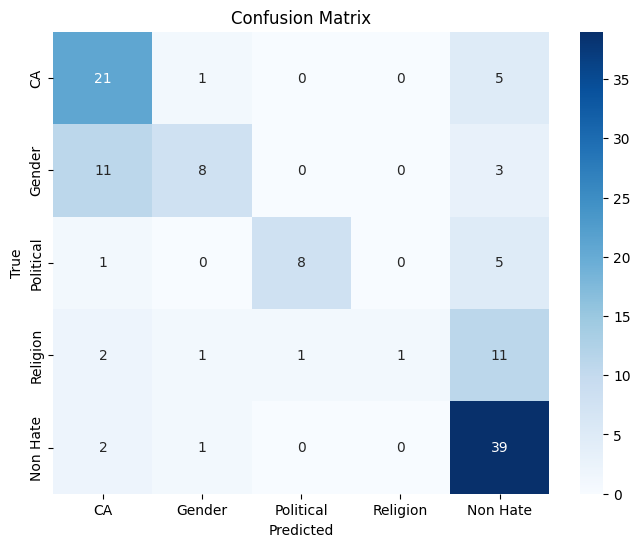

Epoch 3/10 | Train Loss: 0.6642 | Train Acc: 0.7854
Validation Loss: 0.7931 | Validation Acc: 0.7107
Classification Report:
              precision    recall  f1-score   support

          CA       0.66      0.78      0.71        27
      Gender       0.71      0.45      0.56        22
   Political       0.68      0.93      0.79        14
    Religion       0.53      0.56      0.55        16
    Non Hate       0.85      0.79      0.81        42

    accuracy                           0.71       121
   macro avg       0.69      0.70      0.68       121
weighted avg       0.72      0.71      0.71       121



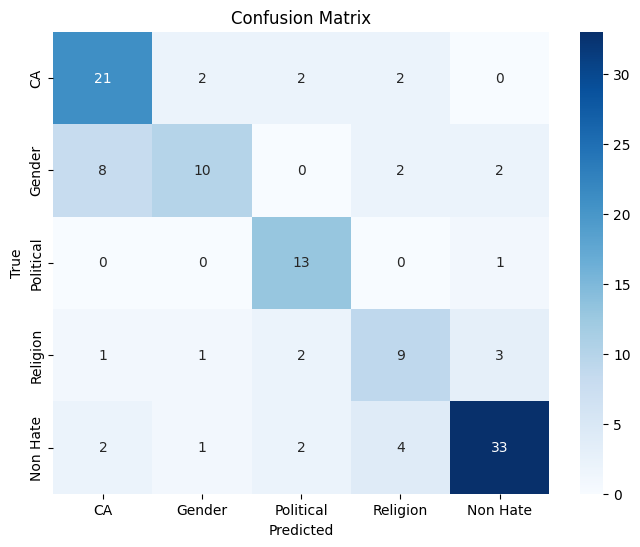

Epoch 4/10 | Train Loss: 0.3930 | Train Acc: 0.8812
Validation Loss: 0.7690 | Validation Acc: 0.7355
Classification Report:
              precision    recall  f1-score   support

          CA       0.73      0.70      0.72        27
      Gender       0.78      0.64      0.70        22
   Political       0.79      0.79      0.79        14
    Religion       0.60      0.75      0.67        16
    Non Hate       0.77      0.79      0.78        42

    accuracy                           0.74       121
   macro avg       0.73      0.73      0.73       121
weighted avg       0.74      0.74      0.74       121



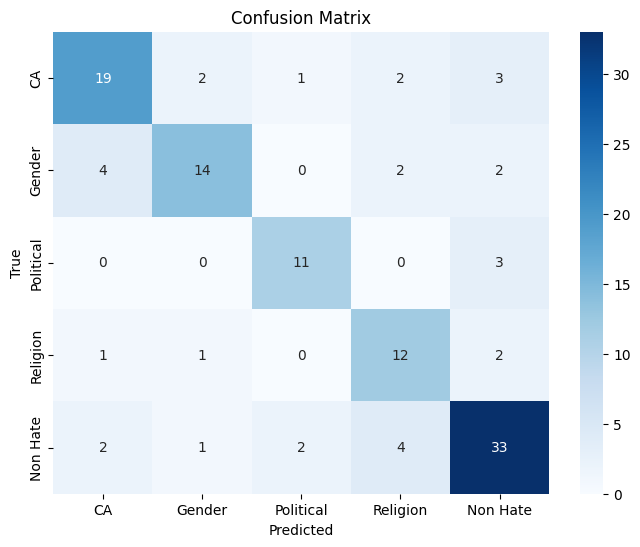

Epoch 5/10 | Train Loss: 0.2345 | Train Acc: 0.9375
Validation Loss: 0.8386 | Validation Acc: 0.7273
Classification Report:
              precision    recall  f1-score   support

          CA       0.68      0.70      0.69        27
      Gender       0.71      0.55      0.62        22
   Political       0.68      0.93      0.79        14
    Religion       0.61      0.69      0.65        16
    Non Hate       0.85      0.79      0.81        42

    accuracy                           0.73       121
   macro avg       0.71      0.73      0.71       121
weighted avg       0.73      0.73      0.73       121



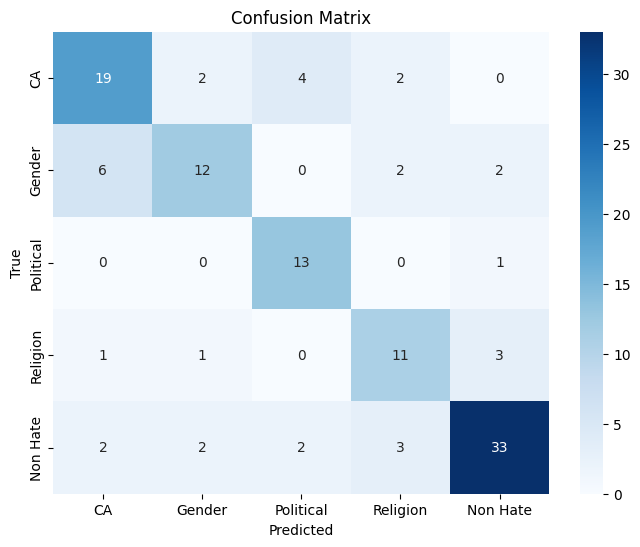

Epoch 6/10 | Train Loss: 0.1321 | Train Acc: 0.9833
Validation Loss: 0.9295 | Validation Acc: 0.7355
Classification Report:
              precision    recall  f1-score   support

          CA       0.70      0.78      0.74        27
      Gender       0.73      0.50      0.59        22
   Political       0.80      0.86      0.83        14
    Religion       0.75      0.56      0.64        16
    Non Hate       0.73      0.86      0.79        42

    accuracy                           0.74       121
   macro avg       0.74      0.71      0.72       121
weighted avg       0.74      0.74      0.73       121



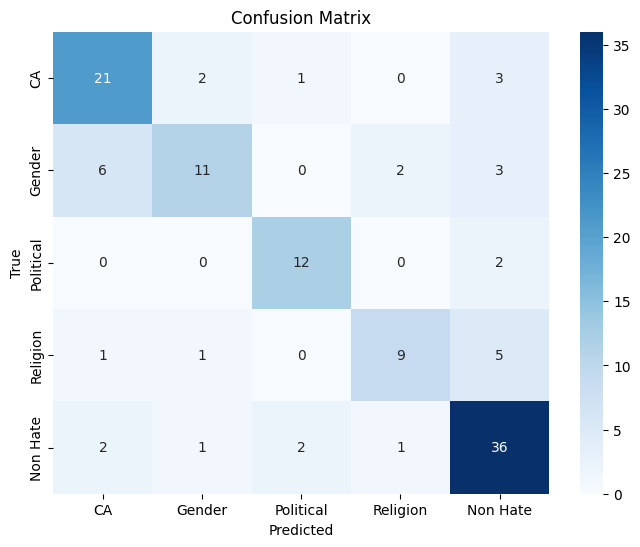

Epoch 7/10 | Train Loss: 0.0694 | Train Acc: 0.9917
Validation Loss: 1.0351 | Validation Acc: 0.7025
Classification Report:
              precision    recall  f1-score   support

          CA       0.69      0.74      0.71        27
      Gender       0.71      0.55      0.62        22
   Political       0.76      0.93      0.84        14
    Religion       0.52      0.69      0.59        16
    Non Hate       0.78      0.69      0.73        42

    accuracy                           0.70       121
   macro avg       0.69      0.72      0.70       121
weighted avg       0.71      0.70      0.70       121



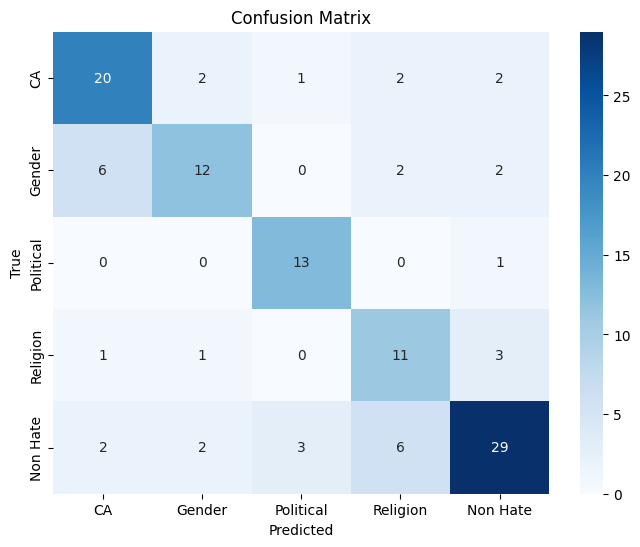

Epoch 8/10 | Train Loss: 0.0369 | Train Acc: 0.9979
Validation Loss: 1.0890 | Validation Acc: 0.7355
Classification Report:
              precision    recall  f1-score   support

          CA       0.68      0.78      0.72        27
      Gender       0.73      0.50      0.59        22
   Political       0.80      0.86      0.83        14
    Religion       0.63      0.75      0.69        16
    Non Hate       0.80      0.79      0.80        42

    accuracy                           0.74       121
   macro avg       0.73      0.73      0.73       121
weighted avg       0.74      0.74      0.73       121



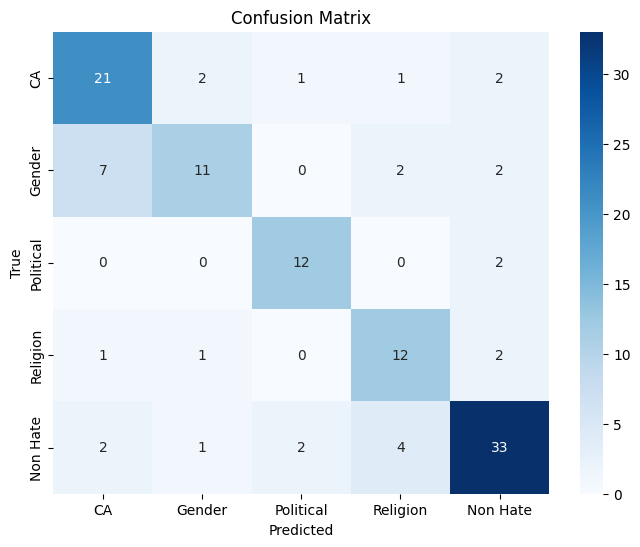

Epoch 9/10 | Train Loss: 0.0250 | Train Acc: 0.9979
Validation Loss: 1.1279 | Validation Acc: 0.7107
Classification Report:
              precision    recall  f1-score   support

          CA       0.69      0.74      0.71        27
      Gender       0.73      0.50      0.59        22
   Political       0.80      0.86      0.83        14
    Religion       0.60      0.56      0.58        16
    Non Hate       0.72      0.81      0.76        42

    accuracy                           0.71       121
   macro avg       0.71      0.69      0.70       121
weighted avg       0.71      0.71      0.71       121



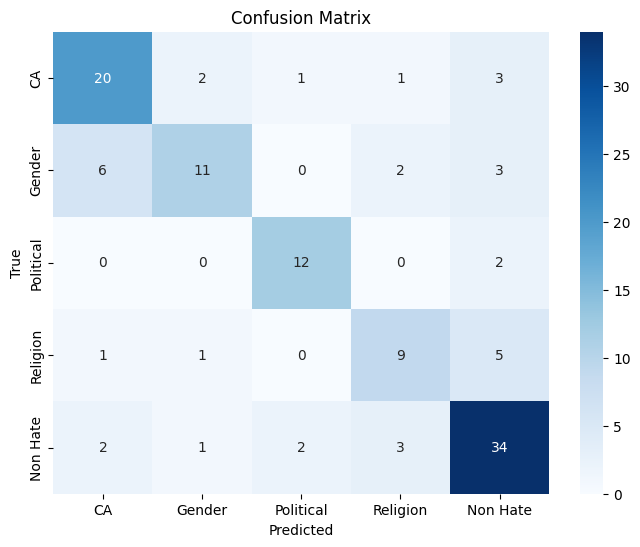

Epoch 10/10 | Train Loss: 0.0155 | Train Acc: 1.0000
Validation Loss: 1.1774 | Validation Acc: 0.7107
Classification Report:
              precision    recall  f1-score   support

          CA       0.69      0.74      0.71        27
      Gender       0.71      0.55      0.62        22
   Political       0.80      0.86      0.83        14
    Religion       0.60      0.56      0.58        16
    Non Hate       0.73      0.79      0.76        42

    accuracy                           0.71       121
   macro avg       0.71      0.70      0.70       121
weighted avg       0.71      0.71      0.71       121



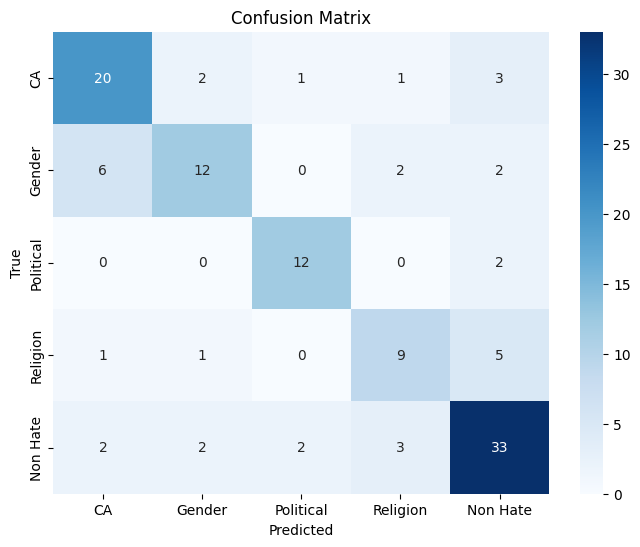

Model saved as attention_fusion_multiclass_model.pth


In [6]:
if __name__ == "__main__":
    main()